<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/4_Why_SPQs_are_usefull%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is intended to assess the effectiveness of Strict Path Queries.

In [ ]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamps
from datetime import datetime, timedelta

In [ ]:
# Access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the two traffic flow datasets
traffic_flow_SPQ = pd.read_csv('traffic_flow_SPQ.csv')
traffic_flow_no_SPQ = pd.read_csv('traffic_flow_without_SPQ.csv')

Change the names of time columns in every time series dataset.

In [ ]:
# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns of the datasets
i = 4
while(True):

    # If it's the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to our dataframes
traffic_flow_SPQ.columns = columns
traffic_flow_no_SPQ.columns = columns

**Preprocess the time series datasets**

In this step, we are doing the following operations:
- Reshape them to long format using melt function
- Preprocess the data types of each column

In [ ]:
# Define a list of columns that will be used as identifiers during the melt operation
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']

# Apply melt function to the first dataset ('traffic_flow_SPQ')
# Get the column names from the third column onwards as time_cols
time_cols = traffic_flow_SPQ.iloc[:,2:].columns

# We reshape the dataframe from wide format to long format,
# keeping the columns in id_cols as identifiers, and the rest of the columns in time_cols are melted into two new columns.
traffic_flow_SPQ = traffic_flow_SPQ.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# Convert the 'Time Column' to datetime format to handle time-related data
traffic_flow_SPQ['Time Column'] = pd.to_datetime(traffic_flow_SPQ['Time Column'])

# Sort rows by 'Path' and 'Time Column' for both datasets in ascending order
traffic_flow_SPQ = traffic_flow_SPQ.sort_values(by=['Path','Time Column']).reset_index(drop=True)

# Add new columns that derive from 'Time Column' column
traffic_flow_SPQ['hour'] = traffic_flow_SPQ['Time Column'].dt.hour # Extracting hour
traffic_flow_SPQ['month'] = traffic_flow_SPQ['Time Column'].dt.month # Extracting month

In [ ]:
# Print 'traffic_flow_SPQ' dataframe
traffic_flow_SPQ.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,month
0,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 10:00:04,0,10,5
1,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 10:30:04,0,10,5
2,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 11:00:04,0,11,5
3,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 11:30:04,1,11,5
4,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 12:00:04,0,12,5


In [ ]:
# Apply melt function to the second dataset ('traffic_flow_no_SPQ')
# re-define the id_cols since the previous id_cols were modified in the first melt operation
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']

# Get the column names from the third column onwards as time_cols for the second dataset
time_cols = traffic_flow_no_SPQ.iloc[:,2:].columns

# Similar to the previous melt operation, it reshapes the dataframe from wide format to long format.
traffic_flow_no_SPQ = traffic_flow_no_SPQ.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# Convert the 'Time Column' to datetime format for the second dataset
traffic_flow_no_SPQ['Time Column'] = pd.to_datetime(traffic_flow_no_SPQ['Time Column'])

# Sort rows by 'Path' and 'Time Column' for both datasets in ascending order
traffic_flow_no_SPQ = traffic_flow_no_SPQ.sort_values(by=['Path','Time Column']).reset_index(drop=True)

# Add new columns that derive from 'Time Column' column
traffic_flow_no_SPQ['hour'] = traffic_flow_no_SPQ['Time Column'].dt.hour # Extracting hour
traffic_flow_no_SPQ['month'] = traffic_flow_no_SPQ['Time Column'].dt.month # Extracting month

In [ ]:
# Print 'traffic_flow_no_SPQ' dataframe
traffic_flow_no_SPQ.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,month
0,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 10:00:04,6,10,5
1,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 10:30:04,6,10,5
2,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 11:00:04,1,11,5
3,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 11:30:04,6,11,5
4,108,5,"[100400941, 100400941, 100400941, 100400941, 1...",20,2008-05-17 12:00:04,0,12,5


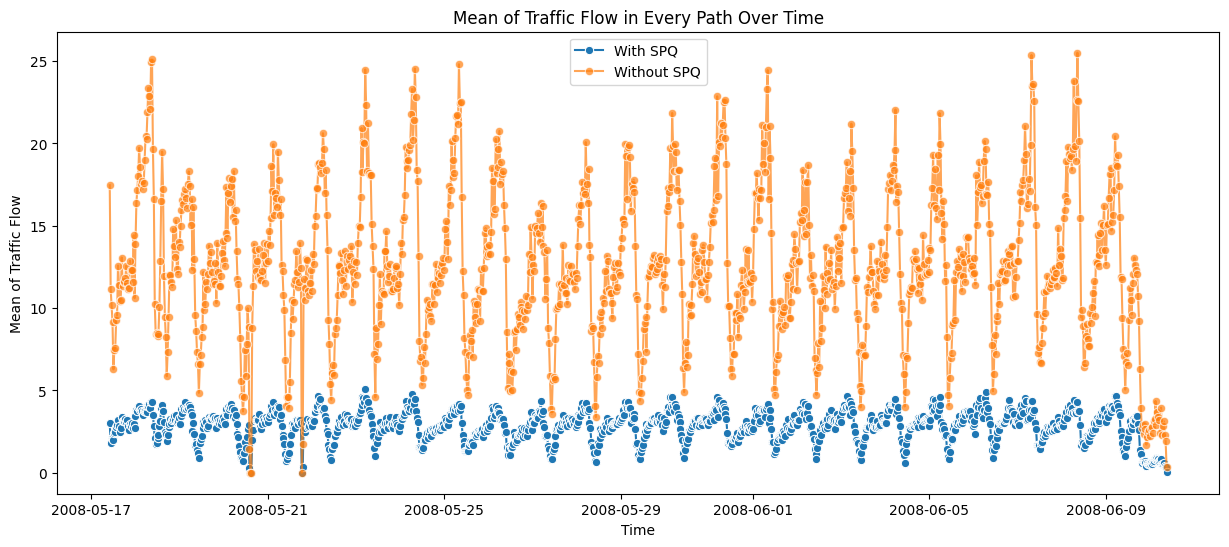

In [ ]:
# Group by the 'Time Column' (timestamp/index) and calculate the mean of the 'Traffic Flow'
# for each timestamp in the 'traffic_flow_SPQ' DataFrame.
avg_grouped_df_SPQ = traffic_flow_SPQ['Traffic Flow'].groupby(traffic_flow_SPQ['Time Column']).mean()

# Convert the resulting Series to a DataFrame, with the timestamp (index) as a new column.
avg_grouped_df_SPQ = pd.DataFrame(avg_grouped_df_SPQ, index=avg_grouped_df_SPQ.index)

# Group by the 'Time Column' (timestamp/index) and calculate the mean of the 'Traffic Flow'
# for each timestamp in the 'traffic_flow_no_SPQ' DataFrame.
avg_grouped_df_no_SPQ = traffic_flow_no_SPQ['Traffic Flow'].groupby(traffic_flow_no_SPQ['Time Column']).mean()

# Convert the resulting Series to a DataFrame, with the timestamp (index) as a new column.
avg_grouped_df_no_SPQ = pd.DataFrame(avg_grouped_df_no_SPQ, index=avg_grouped_df_no_SPQ.index)

# Create a plot to visualize the results
plt.figure(figsize=(15, 6))

# Plot the mean of traffic flow over time for 'avg_grouped_df_SPQ' dataset
sns.lineplot(data=avg_grouped_df_SPQ, x=avg_grouped_df_SPQ.index, y='Traffic Flow', marker='o', linewidth=1.5, label='With SPQ')

# Plot the mean of traffic flow over time for 'avg_grouped_df_no_SPQ' dataset
sns.lineplot(data=avg_grouped_df_no_SPQ, x=avg_grouped_df_no_SPQ.index, y='Traffic Flow', marker='o', linewidth=1.5, alpha=0.7, label='Without SPQ')

# Set the labels for the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Mean of Traffic Flow')

# Set the title for the plot
plt.title('Mean of Traffic Flow in Every Path Over Time')

# Add a legend to distinguish between the two datasets
plt.legend(loc='upper center')

# Display the plot
plt.show()